### This notebook provides the Qiskit implementation of the use case described in the paper.

In particular, the task consists in the classification of multiple sample $s_i$ using the classifier illustrated in [“Implementing a distance-based classifier with an interference circuit”](https://arxiv.org/abs/1703.10793). The notebook shows two circuits that address the same task respectively employing:

1. the Logarithmic Quantum Forking (LQF) technique,
2. the Quantum Forking-based Sampling (QFS) technique.

In [1]:
import qiskit
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, BasicAer, Aer, execute
from qiskit.circuit.library import RYGate, MCMT, RYGate,CRYGate, SwapGate
from qiskit.visualization import plot_histogram
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

### Create a sample dataset with 2 trainings and 2 sample of 2 feature each

In [2]:
"""
We consider a two features (f0,f1) dataset. 
We encode f0,f1 in the amplitude of a qubit by rotating it by the angle returned by arctan2.
"""

X_train = np.array([np.arctan2(0.19,0.9)*2, np.arctan2(-0.4, -0.84)*2])
y_train = [0, 1]
X_sample = np.array([np.arctan2(-0.19,-0.9)*2, np.arctan2(0.6, 0.64)*2])

### Utility functions

In [3]:
def _register_switcher(circuit, value, qubit_index):
    """
        Encodes a value into a bistring in the circuit.
        
        Args:
            circuit (QuantumCircuit): the circuit where to encode the bistring.
            value (int): the value to encode.
            qubit_index (QuantumRegister): the qubit register that encodes the bitstring.
    """
    bin_str_pattern = '{:0%sb}' % len(qubit_index)
    value = bin_str_pattern.format(value)[::-1]
    for idx, bit in enumerate(value):
        if not int(bit):
            circuit.x(qubit_index[idx])


def get_state_preparation_gate(X_train, y_train):
    """
        Returns a quantum state that encodes the trainings into a Flip-Flop QRAM.
    
        Args: 
            X_train (numpy array): the training dataset features.
            y_train (numpy array): the training dataset classes 
    """
    n_trainings = len(X_train)
    n_classes = len(np.unique(y_train))
    
    
    e = QuantumRegister(1, 'e') #qubit encoding feature values
    r = QuantumRegister(1, 'r') #qubit encoding feature values
    m = QuantumRegister(n_training_indexes, 'm') #training index
    c = QuantumRegister(n_class_indexes, 'c') #class
    

    initial_state = QuantumCircuit(e,m,r,c, name="state_preparation")
    
    initial_state.h(m)
    initial_state.h(c)
    
    for idx, x_i, y_i in zip(range(len(X_train)), X_train, y_train):
        _register_switcher(initial_state, idx, m) #Switching index
        _register_switcher(initial_state, y_i, c) #Switching class

        initial_state.mcry(x_i, e[0:]+m[0:]+c[0:], r[0])

        _register_switcher(initial_state, y_i, c) #Switching class
        _register_switcher(initial_state, idx, m) #Switching index
    return initial_state

In [4]:
T = len(X_sample) # the number of T forks is equal the number of samples we classify simultaneously
n_trainings = len(X_train)
n_classes = len(np.unique(y_train))


n_fork_indexes = int(math.ceil(math.log2(T))) # number of qubits to index each fork
n_training_indexes = int(math.ceil(math.log2(n_trainings))) # number of qubits to index the training data
n_class_indexes = int(math.ceil(math.log2(n_classes))) # number of qubits to index each class

# Expected output of single classification (not using forking techniques)

#### Follows the implementation of the distance-based classifier described [here](https://arxiv.org/abs/1703.10793)
We will use it as a ground truth. In particular, we create a distinct circuit for each sample in X_sample, and we retrieve the output class. 

The output class of each circuit is appended in the variable "output_configuration".
We want to assess that the bitstring of outputs in "output_configuration" coincides with the outputs obtained from LQF and QFS techniques.

In [5]:
e = QuantumRegister(1, 'e') # ancilla euclidean distance
r = QuantumRegister(1, 'r') # qubit encoding feature values
m = QuantumRegister(n_training_indexes, 'm') # training indexes
c = QuantumRegister(n_class_indexes, 'c') # class indexes

ce = ClassicalRegister(1, 'ce') # store the measurement of ancilla "e"
cc = ClassicalRegister(n_class_indexes, 'cc') # store the measurement of qubit "c". It corresponds to the classification output.


#Initialize Quantum Circuit
qc = QuantumCircuit(e,m,r,c,cc,ce)

qc.h(e)
qc.append(get_state_preparation_gate(X_train, y_train), [e]+m[0:]+[r]+c[0:])
qc.barrier()

qc.x(e)

#Create distinct copy of qc
qc_arr = []
for i in range(T):
    qc_arr.append(qc.copy())

#For each copy, compute the classification of a different sample x_i
for i, x_i in zip(range(len(X_sample)), X_sample):
    qc_arr[i].mcry(x_i, e[0:], r[0])
    qc_arr[i].h(e)
    qc_arr[i].measure(e,ce)
    qc_arr[i].measure(c,cc)
    qc_arr[i].draw('mpl', fold=30)

In [6]:
output_configuration = '' # bitstring that stores the result of each circuit

shots = [310, 380]
for i in range(len(qc_arr)):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(qc_arr[i], simulator, shots=shots[i]).result()
    counts = result.get_counts(qc_arr[i])

    counts = {k:v for (k,v) in counts.items() if int(k[0])==0} #Post Selection on |e> == 0
    output_qc = max(counts, key=counts.get)[2:2+len(cc)]
    print(counts)
    print(shots[i])
    output_configuration = output_qc + output_configuration

#left-most bit represents the output classification of the last circuit.
print("Expected output employing the forking techniques: {}".format(output_configuration))

{'0 1': 87, '0 0': 1}
310
{'0 1': 79, '0 0': 164}
380
Expected output employing the forking techniques: 01


## Logarithmic Quantum Forking (LQF)

#### Follows the qiskit implementation of the distance-based classfier that employs the LQF technique described in the paper.

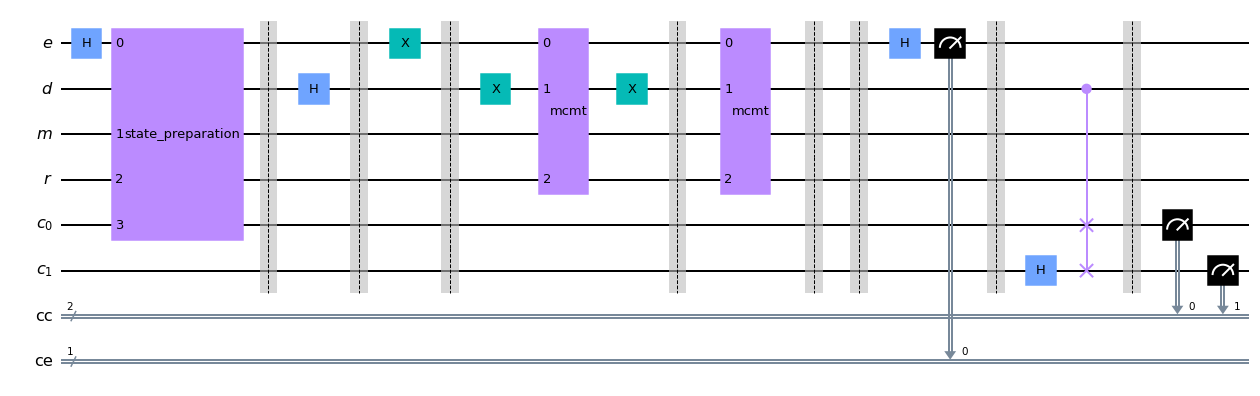

In [7]:
e = QuantumRegister(1, 'e') # ancilla euclidean distance
d = QuantumRegister(n_fork_indexes, 'd') # fork indexes
r = QuantumRegister(1, 'r') # qubit encoding feature values
m = QuantumRegister(n_training_indexes, 'm') # training indexes
c = QuantumRegister(n_class_indexes*T, 'c') # class indexes. |c> is a single quantum register of size n_class_indexes*T that stores the output of each T classification.

ce = ClassicalRegister(1, 'ce') # store the measurement of ancilla "e"
cc = ClassicalRegister(n_class_indexes*T, 'cc') # store the measurement of qubit "c". It corresponds to the classifications output.

qc = QuantumCircuit(e,d,m,r,c,cc,ce)

qc.h(e)


########## FORKING - Prepare the initial state and forking it 2^d = T branches.
qc.append(get_state_preparation_gate(X_train, y_train), [e]+m[0:]+[r]+c[0:n_class_indexes])
qc.barrier()

qc.h(d) #Fork the initial state in 2^d branches.
qc.barrier()

qc.x(e)
qc.barrier()

########## EVOLUTION - Encode samples to be classified
for idx, x_i in zip(range(len(X_sample)), X_sample):
    _register_switcher(qc, idx, d) #Switching fork
    qc.append(MCMT(CRYGate(x_i), num_ctrl_qubits=len(e[0:]+d[0:]), num_target_qubits=1), e[0:]+d[0:]+[r])
    _register_switcher(qc, idx, d) #Switching fork back
    qc.barrier()

    
######### Compute quantum euclidean distance
qc.barrier()
qc.h(e)
qc.measure(e,ce)
qc.barrier()



########## MEASUREMENTS - Retrieve the 2 classifications in 1 shot exploiting LQF
qc.h(c[n_class_indexes:])
ccSwapGate = SwapGate().control(len(d))

for i in range(1,T): #switch fork
    _register_switcher(qc, i, d) #Switching fork
    for j in range(n_class_indexes): #switch index
        qc.append(ccSwapGate, d[0:]+[c[j]]+[c[(n_class_indexes*i+j)]])
    _register_switcher(qc, i, d) #Switching fork back
    qc.barrier()

qc.measure(c,cc)

qc.draw('mpl', fold=30)

LQF Outputs configuration: 01


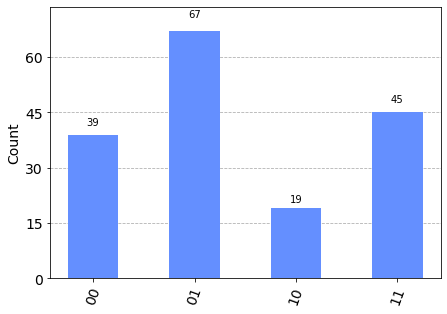

In [8]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, simulator, shots=380).result()
counts = result.get_counts(qc)

# Post Selection on e == 0
counts = {k[2:2+n_class_indexes*T]:v for (k,v) in counts.items() if int(k[0])==0}
output_configuration_lqf = max(counts, key=counts.get)


# The highest probability corresponds to the output assignment configuration.
# Example: given 2 classes and 2 samples, we need 2 qubits |c1c0>: 
#    - c1 stores the result of the last sample,
#    - c0 stores the result of the first sample.
# If the configuration |c1c0> = 01 has the highest probability, it means that the first and the second sample has been classified respectivily as 0 and 1.

print("LQF Outputs configuration: {}".format(output_configuration_lqf))
plot_histogram(counts)

## Quantum Forking-based Sampling (QFS) 

#### Follows the qiskit implementation of the distance-based classfier that employs the QFS technique.

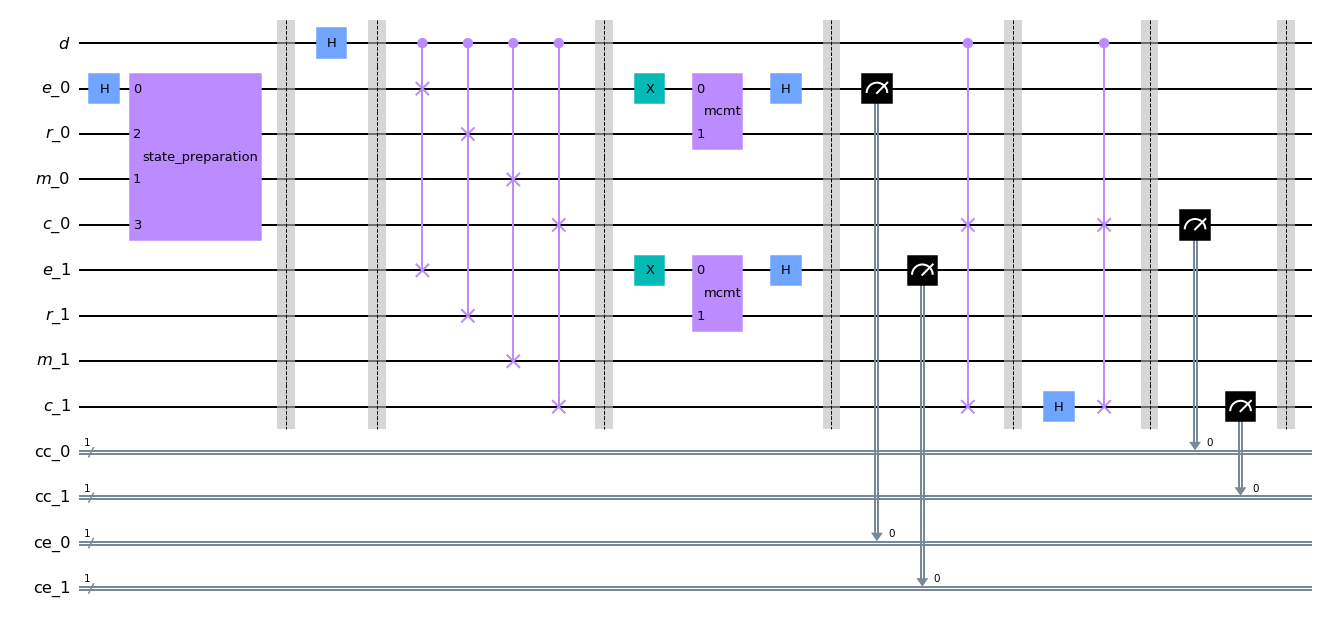

In [9]:
qubits = []
fork_qubits = {}

for i in range(T):
    globals()[f"e_{i}"] = QuantumRegister(1, 'e_'+str(i)) #ancilla euclidean distance
    globals()[f"r_{i}"] = QuantumRegister(1, 'r_'+str(i)) #qubit encoding feature values
    globals()[f"m_{i}"] = QuantumRegister(n_training_indexes, 'm_'+str(i)) #training index
    globals()[f"c_{i}"] = QuantumRegister(n_class_indexes, 'c_'+str(i)) #class
    elems = [globals()[f"e_{i}"],
                        globals()[f"r_{i}"],
                        globals()[f"m_{i}"],
                        globals()[f"c_{i}"]
                       ]
    fork_qubits[i] = elems
    qubits.extend(elems)

cc_arr = []
for i in range(T):
    globals()[f"cc_{i}"] = ClassicalRegister(n_class_indexes, 'cc_'+str(i))
    cc_arr.append(globals()[f"cc_{i}"])
    
ce_arr = []  
for i in range(T):
    globals()[f"ce_{i}"] = ClassicalRegister(1, 'ce_'+str(i))
    ce_arr.append(globals()[f"ce_{i}"])


d = QuantumRegister(n_fork_indexes, 'd') #fork indexes
qc = QuantumCircuit(d,*qubits, *cc_arr, *ce_arr)


########## FORKING - Prepare the initial state and forking it 2^d = T branches.
qc.h(e_0)
qc.append(get_state_preparation_gate(X_train, y_train), [e_0]+m_0[0:]+[r_0]+c_0[0:n_class_indexes])
qc.barrier()

qc.h(d)
qc.barrier()

for i in range(1, T):
    _register_switcher(qc, i, d) #Switching fork
    for j in range(len(fork_qubits[0])): #Switching qubits of fork 0 with fork j
        qc.append(ccSwapGate, d[0:]+[fork_qubits[0][j]]+[fork_qubits[i][j]])
    _register_switcher(qc, i, d)
    qc.barrier()


########## EVOLUTION - Encode samples to be classified
for idx, x_i in zip(range(len(X_sample)), X_sample):
    qc.x(globals()[f"e_{idx}"])
    qc.append(MCMT(CRYGate(x_i), num_ctrl_qubits=len(globals()[f"e_{idx}"]), num_target_qubits=1), [globals()[f"e_{idx}"]]+[globals()[f"r_{idx}"]])

######### Compute quantum euclidean distance
    qc.h(globals()[f"e_{idx}"])
qc.barrier()

for i in range(T):
    qc.measure(globals()[f"e_{i}"],globals()[f"ce_{i}"])


    
########## MEASUREMENTS - Retrieve the 2 classifications in 1 shot exploiting QFS
ccSwapGate = SwapGate().control(len(d))
for i in range(1, T):
    _register_switcher(qc, i, d) # Switching fork
    for j in range(len(globals()[f"c_{0}"])): # Switch index
        qc.append(ccSwapGate, d[0:]+[globals()[f"c_{0}"][j]]+[globals()[f"c_{i}"][j]])
    _register_switcher(qc, i, d) # Switching fork back
    qc.barrier()    
    
    
for i in range(1,T):
    qc.h(globals()[f"c_{i}"])

for i in range(1, T):
    _register_switcher(qc, i, d) # Switching fork
    for j in range(len(globals()[f"c_{0}"])): #switch index
        qc.append(ccSwapGate, d[0:]+[globals()[f"c_{0}"][j]]+[globals()[f"c_{i}"][j]])                                                            
    _register_switcher(qc, i, d) # Switching fork back
    qc.barrier()    
    
for i in range(T):    
    qc.measure(globals()[f"c_{i}"],globals()[f"cc_{i}"])

qc.barrier()

qc.draw('mpl', fold=30)

QFS Outputs configuration: 01


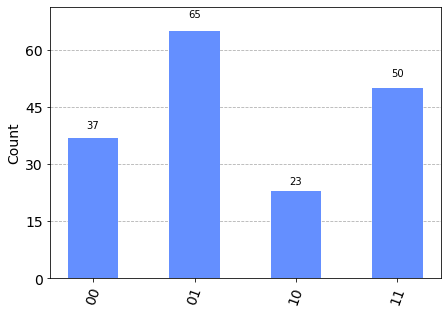

In [10]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, simulator, shots=len(X_sample)*380).result()
counts = result.get_counts(qc)

#Post Selection on e_0,e_1,...,e_{T-1} == 0_0,0_1..0_{T-1}
counts = {k.replace(' ',''):v for (k,v) in counts.items()}

# The number of post-selections grows as the number of samples to classify
post_selection_pattern = '0' * T 
counts = {k[T:T+n_class_indexes*T]:v for (k,v) in counts.items() if k[:T]==post_selection_pattern}
output_configuration_qfs = max(counts, key=counts.get)

# The highest probability corresponds to the output assignment configuration.
# Example: given 2 classes and 2 samples, we need 2 qubits |c1c0>: 
#    - c1 stores the result of the last sample,
#    - c0 stores the result of the first sample.
# If the configuration |c1c0> = 01 has the highest probability, it means that the first and the second sample has been classified respectivily as 0 and 1.

print("QFS Outputs configuration: {}".format(output_configuration_qfs))
plot_histogram(counts)